# IMU Case @Ottobock

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from utilities import extract_features_and_labels

## 1. Data Preprocessing

In [3]:
# --- Data Loading and Merging ---
# Merge CSV files
files = ["IMU_case_dataset_part1_.csv", "IMU_case_dataset_part2_.csv",
         "IMU_case_dataset_part3_.csv", "IMU_case_dataset_part4_.csv"]
df_list = [pd.read_csv(f"data/{f}") for f in files]
df = pd.concat(df_list, ignore_index=True)

# Drop duplicate rows (if any overlap at file boundaries)
df.drop_duplicates(subset=['ID','timestamp'], inplace=True)

# Sort by ID, then by timestamp
df = df.sort_values(['ID', 'timestamp']).reset_index(drop=True)
print("Combined data shape:", df.shape)
print("Example records:\n", df.head(5))

# Percentage of unlabelled data
pcntUnlAct = (1 - sum(df["activity"].notna()) / len(df)) * 100
print(f"\nAbout {round(pcntUnlAct)}% data is not labelled!")

Combined data shape: (1031006, 7)
Example records:
       idx  ID activity      timestamp     X      Y     Z
0  941965   1      NaN  4991922345000  0.69  10.80 -2.03
1  941966   1  Walking  4991972333000  6.85   7.44 -0.50
2  941967   1  Walking  4992022351000  0.93   5.63 -0.50
3  941968   1  Walking  4992072339000 -2.11   5.01 -0.69
4  941969   1  Walking  4992122358000 -4.59   4.29 -1.95

About 60% data is not labelled!


## 2. Feature Extraction

In [4]:
# --- Sliding Window Segmentation and Feature Extraction ---
window_size = 100  # number of samples per window
step_size = 50    # 50% overlap
majority_frac = 0.4  # required fraction to assign label to a window
feature_rows, labels, win_ids, acc, ts = extract_features_and_labels(df, window_size, step_size, majority_frac)

In [5]:
# Create DataFrame of features
feature_df = pd.DataFrame(feature_rows)
feature_df['label'] = labels
feature_df['ID'] = win_ids

feature_df.dropna(
    subset=[c for c in list(feature_df.columns) if c not in ['label']],
    inplace=True
)

feature_df.sample(10, random_state=1)

,mean_X,mean_Y,mean_Z,std_X,std_Y,std_Z,min_X,min_Y,min_Z,max_X,...,mean_mag,std_mag,dom_freq_X,dom_freq_Y,dom_freq_Z,corr_XY,corr_XZ,corr_YZ,label,ID
2052,3.8836,8.7058,1.983804,2.554614,4.191776,3.273545,-0.72,1.27,-6.401564,10.00,...,10.448585,4.522055,0.05,0.11,0.16,0.374074,-0.089767,0.353487,Walking,5
1359,6.3718,7.2971,0.592200,3.734877,3.921157,4.086338,-1.46,0.46,-4.940000,14.67,...,10.643629,5.189826,0.11,0.11,0.11,0.706442,0.459501,0.427216,Walking,3
2164,3.7256,9.1430,1.588950,2.742634,4.648408,3.357012,-0.72,0.46,-3.568531,9.43,...,10.863735,4.730521,0.05,0.10,0.05,0.205237,-0.200148,0.343846,Walking,5
8441,5.0785,9.3209,-0.324437,5.197499,3.382859,2.629392,-4.94,2.53,-6.047434,19.46,...,11.945171,3.931910,0.09,0.09,0.28,0.068929,0.187198,-0.056574,None,15
15882,7.3610,7.4724,-0.959009,7.684154,8.586436,4.773243,-4.18,-6.74,-9.534244,19.34,...,14.211850,8.032500,0.08,0.16,0.35,0.504296,0.319075,-0.120444,None,29
20420,-0.7634,9.6524,1.813958,1.385746,2.570594,1.803127,-4.86,4.90,-2.955615,3.41,...,10.084896,2.667665,0.05,0.09,0.04,0.150172,0.081938,0.241988,Downstairs,36
9939,7.4155,-1.0812,-0.508700,9.979407,9.363709,4.717054,-12.64,-19.34,-11.300000,19.95,...,14.695220,7.070087,0.13,0.05,0.11,0.179739,-0.343352,-0.309924,None,19
17286,7.5326,4.0597,0.164900,8.446625,8.565404,4.602578,-3.17,-8.73,-9.620000,19.95,...,12.790500,8.691770,0.14,0.14,0.19,0.447417,0.191444,-0.064904,None,31
13248,-1.0754,8.7259,-0.123900,6.833799,8.972612,4.794393,-13.53,-16.66,-11.410000,17.39,...,14.296643,4.807698,0.13,0.13,0.18,-0.367713,-0.111443,-0.374714,None,24
12934,1.6597,8.0155,-1.394600,8.108075,10.383545,8.698345,-19.11,-18.77,-15.980000,17.67,...,17.074335,5.160906,0.15,0.22,0.15,0.009323,-0.572131,0.375027,Jogging,23


## 3. Classification + Auto-labelling (confidence filtering)

In [6]:
# Split train/test by participant IDs
test_ids = np.arange(31, 37)

# Train set: windows from IDs not in test_ids
train_df = feature_df[~feature_df['ID'].isin(test_ids)].reset_index(drop=True)
test_df  = feature_df[ feature_df['ID'].isin(test_ids)].reset_index(drop=True)

# Separate features and labels
X_train, y_train= train_df.drop(columns=['label','ID']), train_df['label']
X_test, y_test  = test_df.drop(columns=['label','ID']), test_df['label']
print("Total windows:", feature_df.shape[0],
      "-- Train windows:", len(X_train), ", Test windows:", len(X_test))
print("Labeled train windows:", y_train.notna().sum(),
      "| Unlabeled train windows:", y_train.isna().sum())
print("Labeled test windows:", y_test.notna().sum(),
      "| Unlabeled test windows:", y_test.isna().sum())

Total windows: 20563 -- Train windows: 16774 , Test windows: 3789
Labeled train windows: 8596 | Unlabeled train windows: 8178
Labeled test windows: 2053 | Unlabeled test windows: 1736


In [7]:
# Encode labels
label_encoder = {lab: i for i, lab in enumerate(sorted(y_train[y_train.notna()].unique()))}
inverse_label_encoder = {v: k for k, v in label_encoder.items()}

In [9]:
from utilities import  train_classifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

CONF_THRESHOL = 0.5
N_ESTIMATORS = 400

lr_cls, _, _, lr_test_acc_history, lr_f1_wtd_history, lr_newly_labeled_counts = train_classifier(
    LogisticRegression, X_train, y_train, X_test, y_test, CONF_THRESHOL
)

rf_cls, _, _, rf_test_acc_history, rf_f1_wtd_history, rf_newly_labeled_counts = train_classifier(
    RandomForestClassifier, X_train, y_train, X_test, y_test, CONF_THRESHOL, N_ESTIMATORS
)

xgb_cls, _, _, xgb_test_acc_history, xgb_f1_wtd_history, xgb_newly_labeled_counts = train_classifier(
    XGBClassifier, X_train, y_train, X_test, y_test, CONF_THRESHOL, N_ESTIMATORS
)

models = [lr_cls, rf_cls, xgb_cls]


-------- Training LogisticRegression model --------

Iteration 1


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7353 | Weighted F1 Score: 0.8453
Labelled 7334/8178 samples using confidence filtering (conf >= 0.50)

Iteration 2


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7240 | Weighted F1 Score: 0.8346
Labelled 380/844 samples using confidence filtering (conf >= 0.50)

Iteration 3


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7228 | Weighted F1 Score: 0.8295
Labelled 64/464 samples using confidence filtering (conf >= 0.50)

Iteration 4


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7183 | Weighted F1 Score: 0.8265
Labelled 28/400 samples using confidence filtering (conf >= 0.50)

Iteration 5


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7190 | Weighted F1 Score: 0.8280
Labelled 18/372 samples using confidence filtering (conf >= 0.50)

Iteration 6


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7208 | Weighted F1 Score: 0.8316
Labelled 5/354 samples using confidence filtering (conf >= 0.50)

Iteration 7


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7221 | Weighted F1 Score: 0.8343
Labelled 9/349 samples using confidence filtering (conf >= 0.50)

Iteration 8


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7243 | Weighted F1 Score: 0.8336
Labelled 17/340 samples using confidence filtering (conf >= 0.50)

Iteration 9


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7194 | Weighted F1 Score: 0.8312
Labelled 10/323 samples using confidence filtering (conf >= 0.50)

Iteration 10


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7223 | Weighted F1 Score: 0.8296
Labelled 4/313 samples using confidence filtering (conf >= 0.50)

Iteration 11


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7172 | Weighted F1 Score: 0.8267
Labelled 3/309 samples using confidence filtering (conf >= 0.50)

Iteration 12


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7229 | Weighted F1 Score: 0.8304
Labelled 8/306 samples using confidence filtering (conf >= 0.50)

Iteration 13


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7159 | Weighted F1 Score: 0.8252
Labelled 3/298 samples using confidence filtering (conf >= 0.50)

Iteration 14


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7219 | Weighted F1 Score: 0.8283
Labelled 4/295 samples using confidence filtering (conf >= 0.50)

Iteration 15


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test | Balanced Accuracy: 0.7173 | Weighted F1 Score: 0.8261
No high-confidence predictions this iteration
Remaining unlabelled window samples = 291

Final LogisticRegression model trained on 16483 samples.

-------- Training RandomForestClassifier model --------

Iteration 1
Test | Balanced Accuracy: 0.8072 | Weighted F1 Score: 0.8735
Labelled 7682/8178 samples using confidence filtering (conf >= 0.50)

Iteration 2
Test | Balanced Accuracy: 0.8246 | Weighted F1 Score: 0.8789
Labelled 212/496 samples using confidence filtering (conf >= 0.50)

Iteration 3
Test | Balanced Accuracy: 0.8224 | Weighted F1 Score: 0.8786
Labelled 72/284 samples using confidence filtering (conf >= 0.50)

Iteration 4
Test | Balanced Accuracy: 0.8198 | Weighted F1 Score: 0.8770
Labelled 26/212 samples using confidence filtering (conf >= 0.50)

Iteration 5
Test | Balanced Accuracy: 0.8271 | Weighted F1 Score: 0.8802
Labelled 16/186 samples using confidence filtering (conf >= 0.50)

Iteration 6
Test | Balanced Acc

In [10]:
# Evaluation on test set - only on windows that have an actual label
from sklearn.metrics import classification_report

for model in models:
      print(f"\n-------- {type(model).__name__} --------\n")
      test_mask = y_test.notna()
      X_test_eval = X_test[test_mask]
      y_test_eval = y_test[test_mask]
      y_test_enc = y_test_eval.map(label_encoder)

      y_pred_enc = model.predict(X_test_eval)
      y_pred_labels = [list(label_encoder.keys())[i] for i in y_pred_enc]

      print("Test Classification Report (for labelled test data):")
      print(classification_report(y_test_eval, y_pred_labels))


-------- LogisticRegression --------

Test Classification Report (for labelled test data):
              precision    recall  f1-score   support

  Downstairs       0.73      0.34      0.46       169
     Jogging       0.95      0.92      0.93       643
     Sitting       0.76      1.00      0.86       140
    Standing       1.00      0.51      0.68        92
    Upstairs       0.68      0.58      0.63       200
     Walking       0.81      0.95      0.88       809

    accuracy                           0.84      2053
   macro avg       0.82      0.72      0.74      2053
weighted avg       0.84      0.84      0.83      2053


-------- RandomForestClassifier --------

Test Classification Report (for labelled test data):
              precision    recall  f1-score   support

  Downstairs       0.70      0.54      0.61       169
     Jogging       1.00      0.95      0.98       643
     Sitting       0.82      1.00      0.90       140
    Standing       1.00      0.65      0.79        9

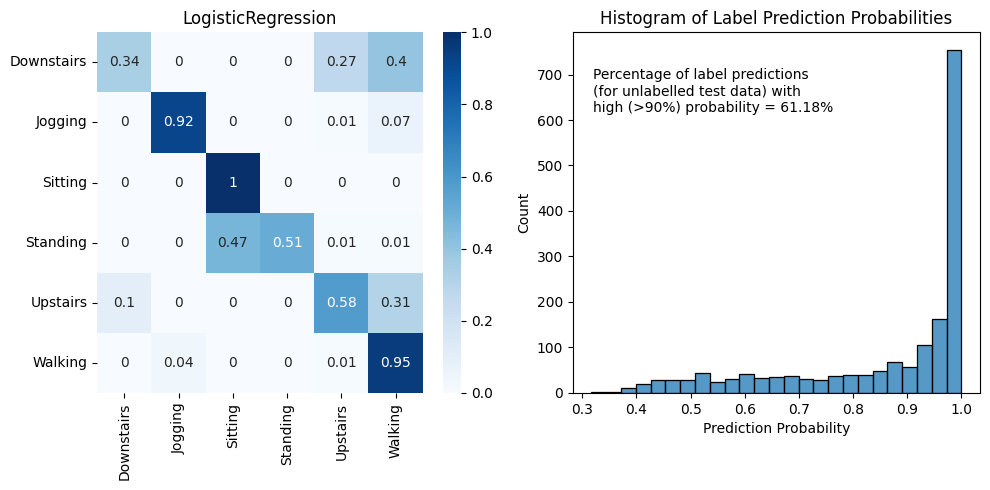

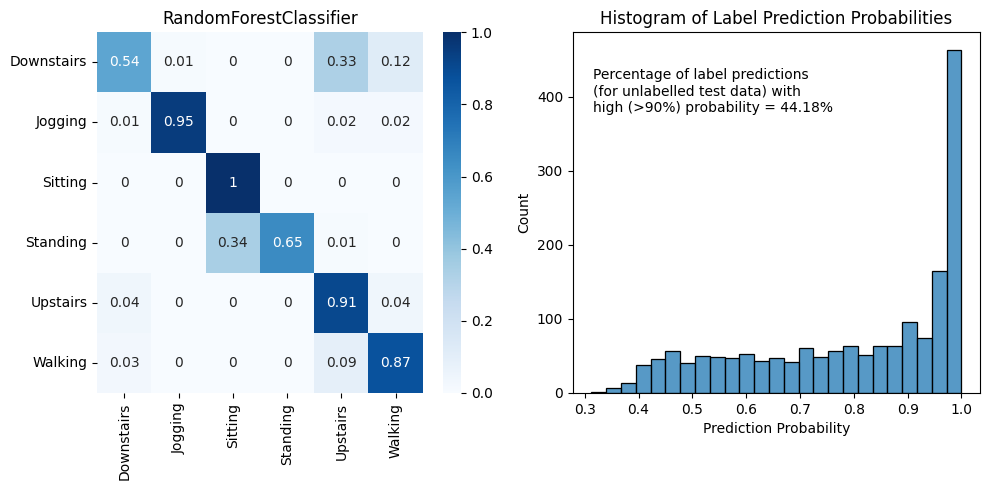

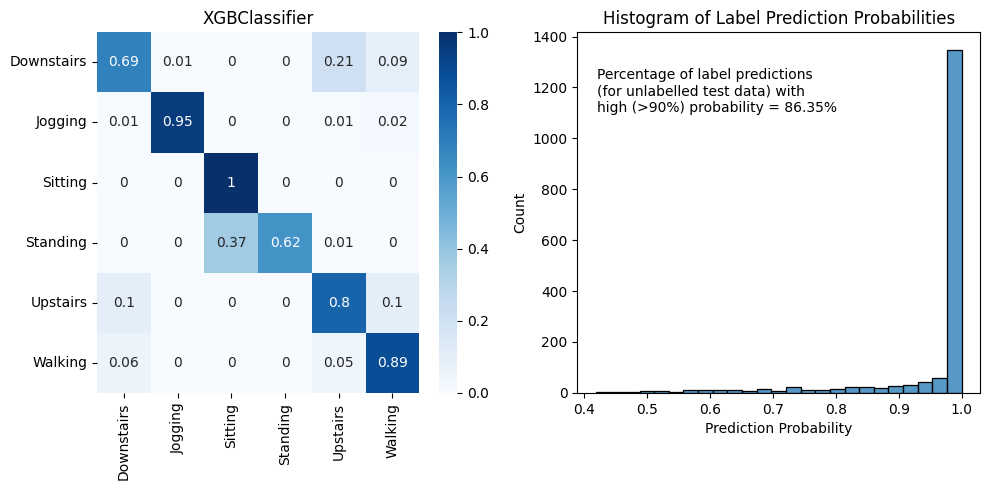

In [11]:
from sklearn.metrics import confusion_matrix

for model in models:
    test_mask = y_test.notna()
    X_test_eval = X_test[test_mask]
    y_test_eval = y_test[test_mask]
    y_pred_enc = model.predict(X_test_eval)
    y_pred_labels = [list(label_encoder.keys())[i] for i in y_pred_enc]

    labels_order = list(label_encoder.keys())
    cm = confusion_matrix(y_test_eval, y_pred_labels, labels=labels_order)
    cm = np.round((cm.T / cm.sum(axis=1)).T , 2)

    # Evaluation on test set - only on windows that have no actual label
    test_mask = y_test.isna()
    X_test_isna_eval = X_test[test_mask]

    y_test_isna_pred_enc = model.predict(X_test_isna_eval)
    y_test_isna_pred_prob = model.predict_proba(X_test_isna_eval)
    y_test_isna_pred_labels = [list(label_encoder.keys())[i] for i in y_test_isna_pred_enc]
    y_test_isna_gt90pcnt_conf = (y_test_isna_pred_prob >= 0.9).sum() / len(y_test_isna_pred_prob)

    prob_test = f"Percentage of label predictions \n(for unlabelled test data) with\n" + \
        f"high (>90%) probability = {round(y_test_isna_gt90pcnt_conf * 100, 2)}%"

    fig, ax = plt.subplots(ncols=2, figsize=(10,5))
    sns.heatmap(
        data=pd.DataFrame(cm, columns=label_encoder),
        ax=ax[0], cmap="Blues", annot=True, yticklabels=labels_order,
    )
    ax[0].set_title(f'{type(model).__name__}')
    sns.histplot(y_test_isna_pred_prob.max(axis=1), ax=ax[1], bins=25)
    ax[1].text(
        0.05, 0.9, prob_test, transform=ax[1].transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(facecolor='white', edgecolor="white", boxstyle='round,pad=0.3')
    )
    ax[1].set_title('Histogram of Label Prediction Probabilities')
    ax[1].set_xlabel('Prediction Probability')

    plt.tight_layout()